In [30]:
# pylint: disable=all
import logging
import tests
import numpy as np
import matplotlib.pyplot as plt
import quadtree_helper
from exactpack.solvers.riemann import IGEOS_Solver

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s:%(module)s:%(funcName)s | %(message)s')
min_resolution = 16
max_resolution = 256
(cfg, target_time) = tests.sod_shock_tube(res=(max_resolution, max_resolution))

In [102]:
# def depth_formula_sod(x, y, max_depth, min_depth, center_x=0.5, center_y=0.5):
#     # Rotation matrix
#     # | cos(θ) -sin(θ) |
#     # | sin(θ)  cos(θ) |

#     count = 15
#     for i,a in enumerate(np.linspace(1.0, 1.5, count)):
#         theta = np.pi * a
#         M = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
#         center = np.array([center_x, center_y])
#         rot = ((np.array([x, y])) - 2.0 * center) @ M
#         # print(rot)

#         if rot[1] < 1/count:
#             return max_depth - (i%2 * 2)
    
#     return min_depth

def depth_formula_sod(x, y, max_depth, min_depth, center_x=0.5, center_y=0.5):
    # Rotation matrix
    # | cos(θ) -sin(θ) |
    # | sin(θ)  cos(θ) |

    theta = np.pi * 1.1
    M = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    center = np.array([center_x, center_y])
    rot = ((np.array([x, y])) - center) @ M + center
    # print(rot)

    count = 10
    for i,v in enumerate(np.linspace(0.0, 1.0, count)):
        if rot[1] < v:
            return max_depth - (i%2 * 3)
    
    return min_depth

In [103]:
tests.gen_quadtree(1,1, int(np.log2(min_resolution)), int(np.log2(max_resolution)), max_resolution, depth_formula_sod)
sqmap = quadtree_helper.read_sqmatrix_from_file()
depth,_,_ = quadtree_helper.read_nodes_from_file()
depth = np.array(depth)

2025-01-26 21:44:02,933 | INFO:tests:gen_quadtree | Generating quadtree with min_depth=4, max_depth=8, max_resolution=256
2025-01-26 21:44:07,698 | INFO:tests:gen_quadtree | Generating helper constructs
2025-01-26 21:44:08,276 | INFO:tests:gen_quadtree | Leaf nodes: 35599, Virtual nodes: 1683
2025-01-26 21:44:08,276 | INFO:tests:gen_quadtree | Writing nodes to file
2025-01-26 21:44:08,318 | INFO:tests:gen_quadtree | Creating and writing square grid map to file
2025-01-26 21:44:08,557 | INFO:tests:gen_quadtree | Creating and writing boundary cell map to file
2025-01-26 21:44:08,569 | INFO:tests:gen_quadtree | Quadtree generation completed


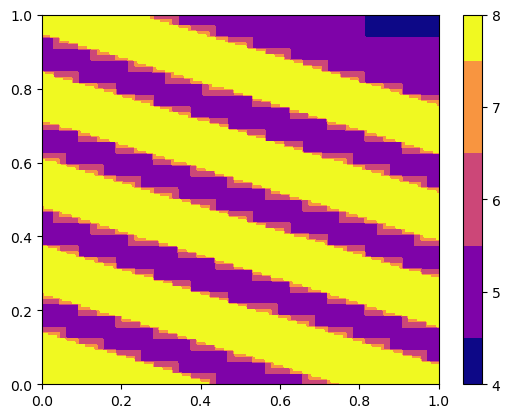

In [104]:
cmap = plt.get_cmap('plasma', np.max(depth[sqmap]) - np.min(depth[sqmap]) + 1)
contour = plt.contourf(depth[sqmap][::-1], extent=(0, 1, 0, 1), cmap=cmap,
                          vmin=np.min(depth[sqmap]) - 0.5, vmax=np.max(depth[sqmap]) + 0.5)

plt.colorbar(contour, ticks=np.arange(np.min(depth[sqmap]), np.max(depth[sqmap]) + 1))


In [105]:
space = tests.Quadtree(cfg, use_torch=False)
sim = tests.no_tvd_simulation(space)

(states,times) = sim.run(target_time=target_time,checkpoint_freq=20, no_iter=False)
states = np.array([space.to_grid(state) for state in states])


2025-01-26 21:44:14,715 | INFO:sim_upwind_simple:run | Max number of iterations: 72916
2025-01-26 21:44:14,786 | INFO:sim_upwind_simple:run | iter: 0, dt: 0.0007003292632818713, total: 0.0007003292632818713 [Saved]
2025-01-26 21:44:14,862 | INFO:sim_upwind_simple:run | iter: 1, dt: 0.0004614314233495997, total: 0.001161760686631471
2025-01-26 21:44:14,940 | INFO:sim_upwind_simple:run | iter: 2, dt: 0.0004422760393517542, total: 0.0016040367259832252
2025-01-26 21:44:14,998 | INFO:sim_upwind_simple:run | iter: 3, dt: 0.00043531205822283783, total: 0.0020393487842060632
2025-01-26 21:44:15,058 | INFO:sim_upwind_simple:run | iter: 4, dt: 0.0004323895287452191, total: 0.0024717383129512823
2025-01-26 21:44:15,126 | INFO:sim_upwind_simple:run | iter: 5, dt: 0.00042202989873410307, total: 0.0028937682116853855
2025-01-26 21:44:15,192 | INFO:sim_upwind_simple:run | iter: 6, dt: 0.00041267119630998864, total: 0.003306439407995374
2025-01-26 21:44:15,259 | INFO:sim_upwind_simple:run | iter: 7, 

2025-01-26 21:54:45,529 | INFO:animation:save | Animation.save using <class 'matplotlib.animation.HTMLWriter'>


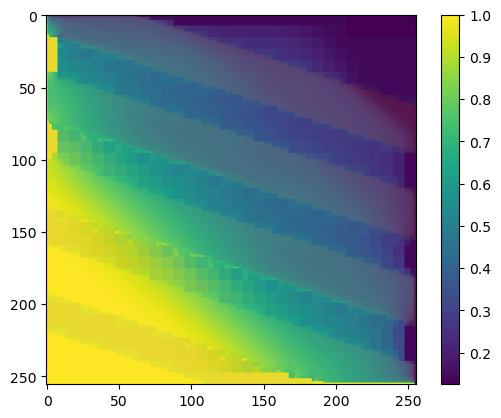

In [128]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Initialize plot
fig, ax = plt.subplots()

# Set up the initial imshow
img1 = ax.imshow(states[0, 0], alpha=1)
img2 = ax.imshow(depth[sqmap], alpha=0.1)
cbar = fig.colorbar(img1)

def update(i):
    img1.set_data(states[i, 0])  # Update the state plot
    return [img1]  # Return the updated images

# Create animation
ani = FuncAnimation(fig, update, frames=range(len(states)), interval=100, blit=True)

# Display animation in the notebook
HTML(ani.to_jshtml())


2025-01-26 22:03:33,575 | INFO:animation:save | Animation.save using <class 'matplotlib.animation.HTMLWriter'>


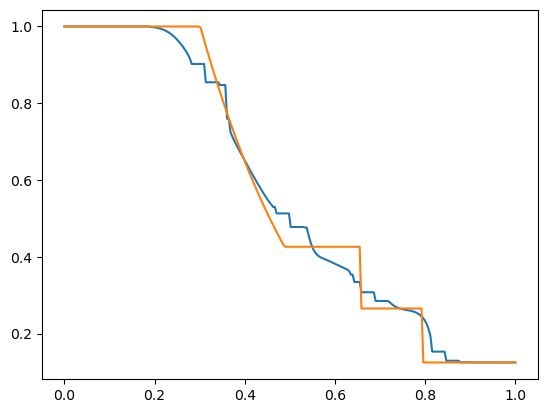

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming 'states' and 'IGEOS_Solver' are defined
# states = ...
# IGEOS_Solver = ...

# Initialize the plot
fig, ax = plt.subplots()

# Set up the initial line for Quadtree (empty at first)

x = (np.linspace(0., 1., states[0][0].shape[0]))
time = times[0]
cp = states[0, 0].copy()
idx = np.diag_indices(cp.shape[0])

y = cp[::-1][idx]

# Set up the solver
solver = IGEOS_Solver( 
                    rl=1.0, ul=0., pl=1.0, gl=1.4,
                    rr=0.125, ur=0., pr=0.1, gr=1.4,
                    xmin=0., xd0=0.5, xmax=1., t=0.168
                )

solu = solver._run(x, t=0.168)
line1, = ax.plot(x, y, label=f"Quadtree")
line2, = ax.plot(x, solu["density"], label="Exact Solution")

# Function to update the plot for each frame
def update(i):
    # Update the Quadtree line for each frame
    cp = states[i, 0].copy()
    idx = np.diag_indices(cp.shape[0])
    
    y = cp[::-1][idx]

    line1.set_data(x, y)

    # Run the solver and update the exact solution line
    solu = solver._run(x, t=0.168)
    line2.set_data(x, solu["density"])

    return line1, line2

# Create the animation
ani = FuncAnimation(fig, update, frames=range(len(states)), interval=100, blit=True)

# Display the animation in the Jupyter notebook
from IPython.display import HTML
HTML(ani.to_jshtml())